In [1]:
import IPython.display as ipd

# 「MIR-02_4」音频特征小全之乐音特征

> 乐音特征(harmonic feature)简单概括就是许多方便检测音高/旋律/和弦的特征。

**♬ 本文为MIR音乐信息检索系列的第2.4篇文章 ♬**

**♬ 该文与2.1概览+2.2时域特征+2.3频域特征及后续2.5特征提取工具共同组成音频特征小全 ♬**

本文将大致讲解以下问题中涉及到的乐音特征：
- 什么是音高？它与基音和泛音有什么联系？
- 如何识别一首歌的音高变化？
- 如何识别一首歌的和弦进行？

---

### 『音高』

音高(pitch)可以指我们“感觉上”的声音的高低。大多数情况下，音高由乐器发出的基本频率决定（简称为基频fundamental frequency即F0，单位为赫兹Hz），越高的音高对应的F0数值越大。但是乐器发出的每个音不仅仅包括基频正弦波的“基音”，还同时由许多频率较高的正弦波也就是“泛音”组成。基音与泛音这些不同频率的正弦波的叠加才是我们真正听到的音。

来，我们直接给钢琴中央C的单音音频做个离散傅里叶变换，得到下方的频谱图，红色点对应的横轴频率值为262.4Hz即F0，黑色点点们则对应了泛音。

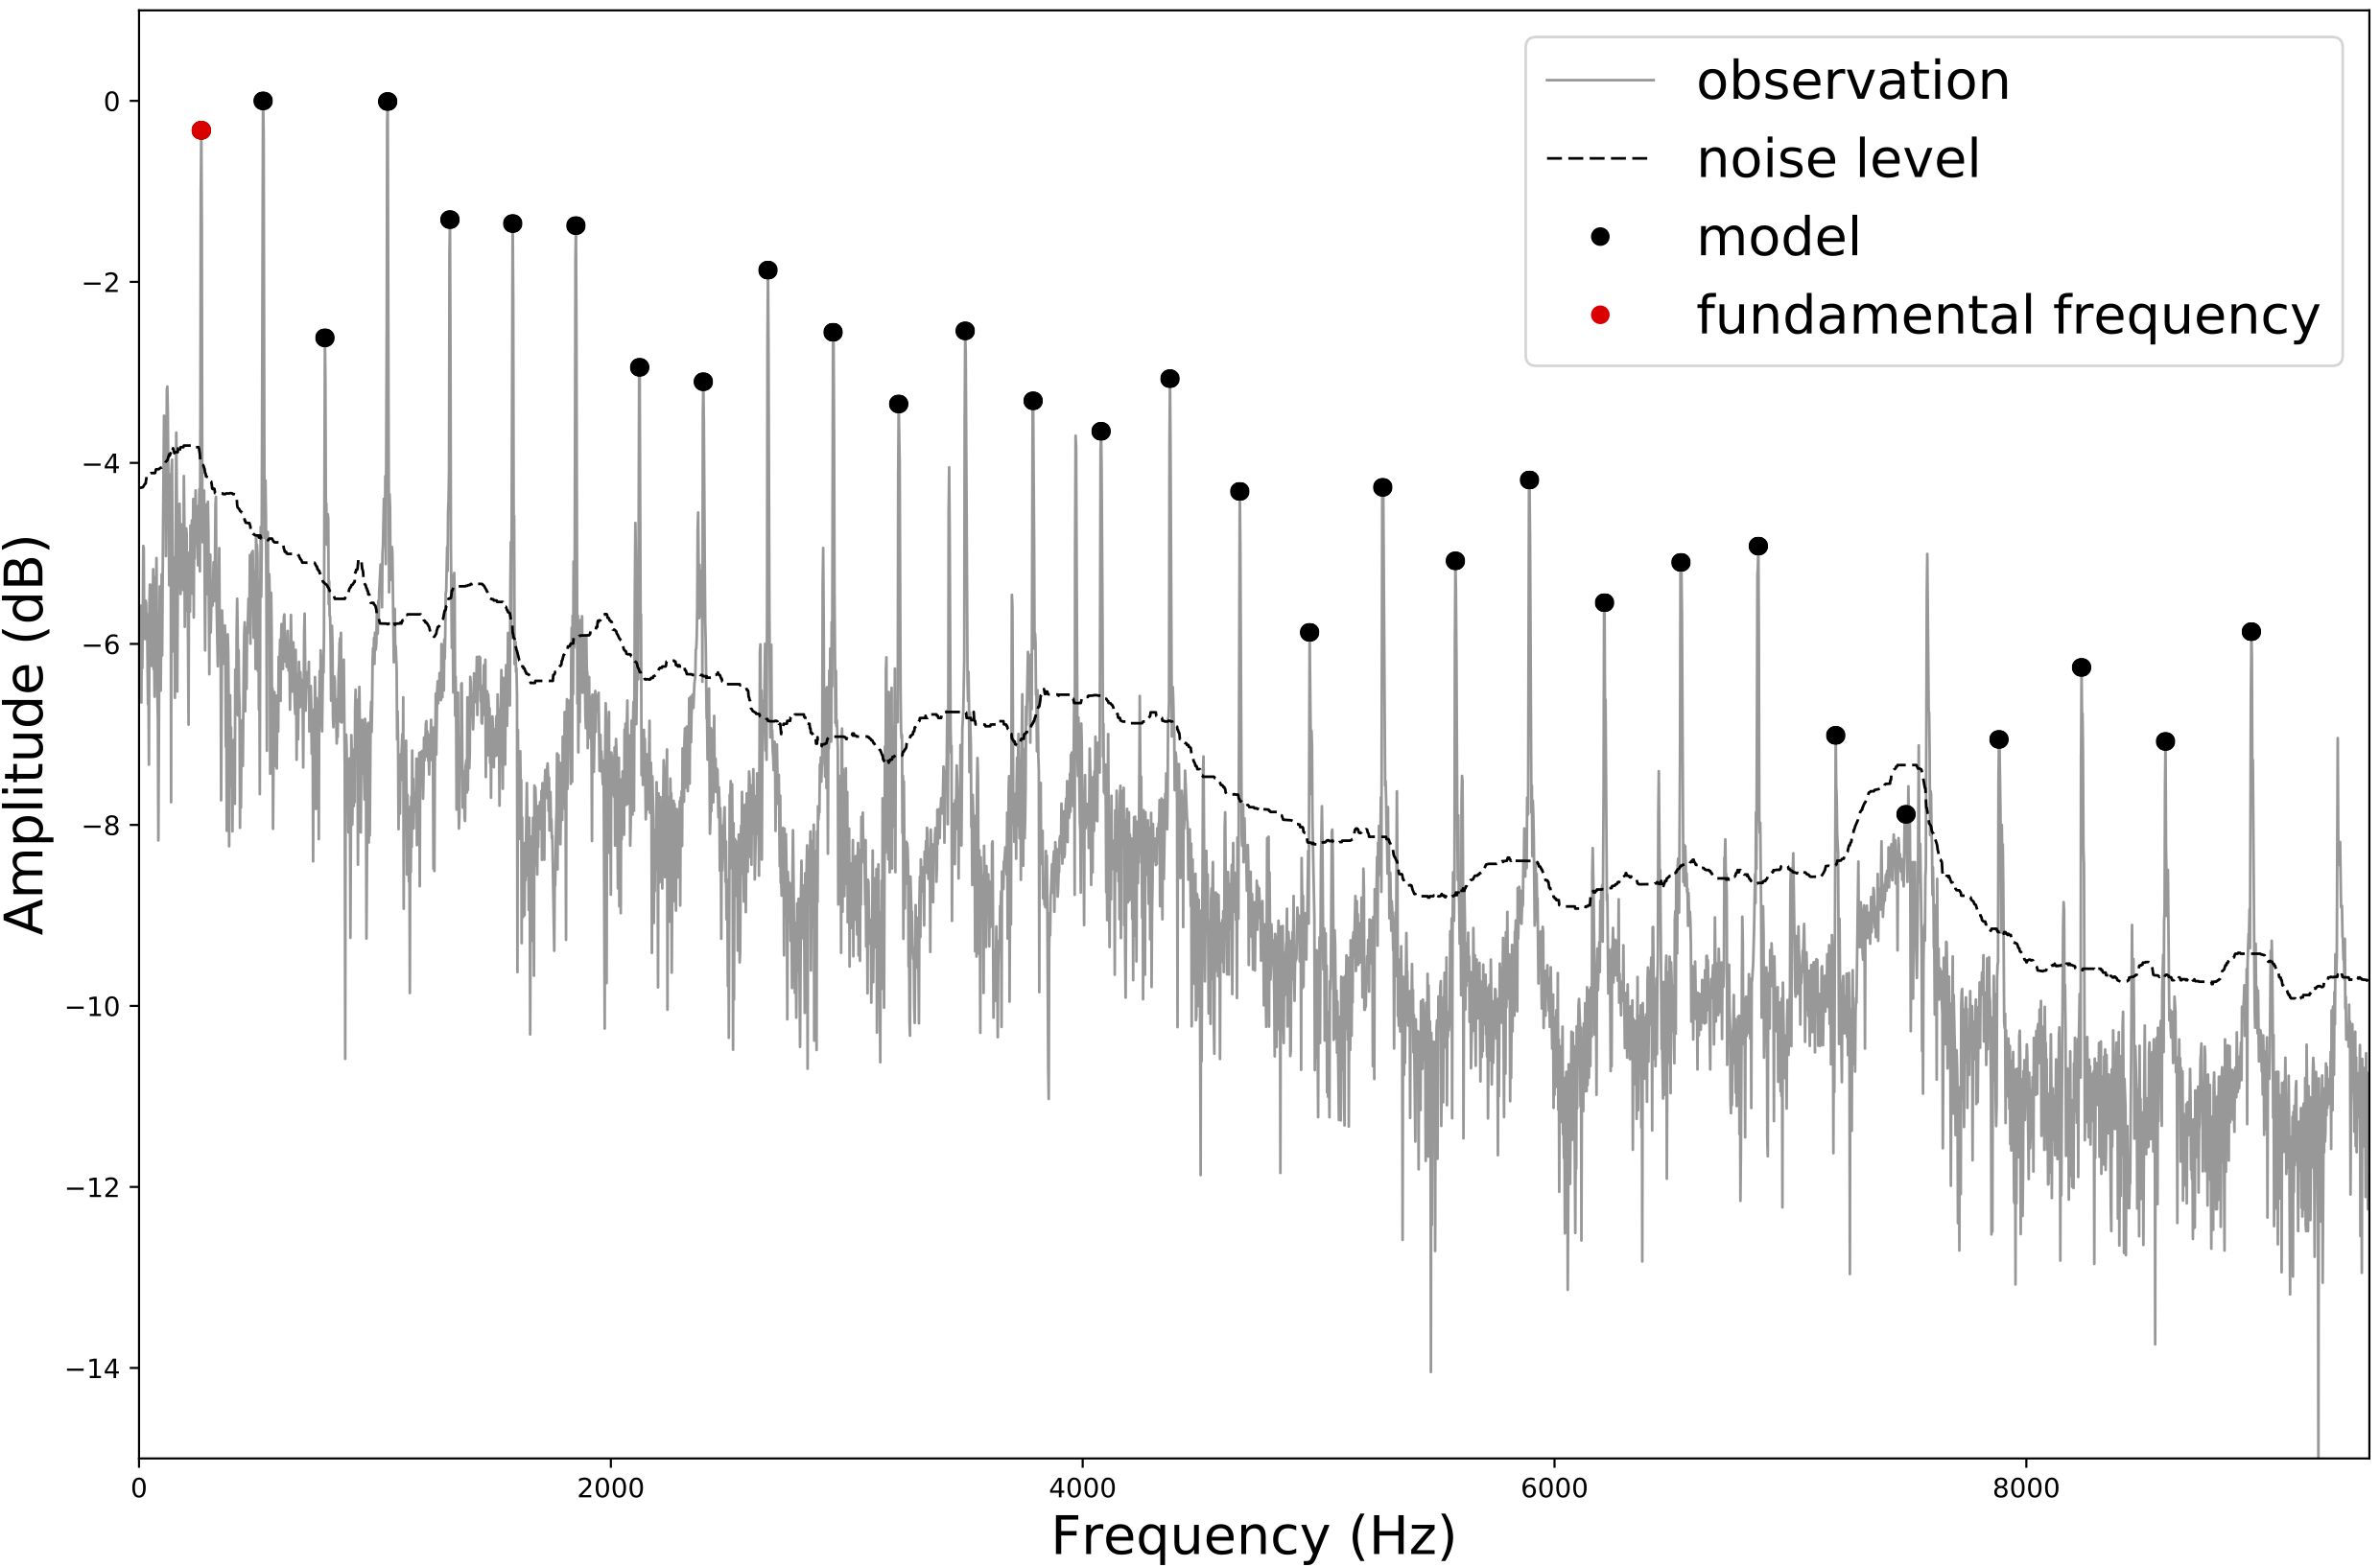

In [3]:
ipd.Image("attachment/mir02-c4.png")

理想情况下，泛音和基音之间的频率值应该是整数倍的关系，由于钢琴本身的物理特性，第n个泛音和基音之间关系其实是

$$f_{n} = nf_{0}\sqrt{1 + Bn^2}$$

其中B称为不谐和系数，且钢琴88个音中每个音的B值都不同。

✎ 给定钢琴每个音的音频，如何从各个音频中估计每个音的F0与B，可参考文献[F. Rigaud, B. David, and L. Daudet, “A parametric model and estimation techniques for the inharmonicity and tuning of the piano”, The Journal of the Acoustical Society of America, vol. 133, no. 5, pp. 3017–3118, 2013.](https://asa.scitation.org/doi/10.1121/1.4799806)

☞ 上方文献的python2代码实现可参见我的GitHub https://github.com/beiciliang/estimate-f0-inharmonicity 

☞ Matlab代码可参见Tian Cheng的 https://code.soundsoftware.ac.uk/projects/inharmonicityestimation

---

### 『音高识别』

在MIR学界中，一大主流方向就是识别音频中每一帧内的音高或基频(pitch/F0 estimation)。最简单的情况是音频中只有一个声源，且该声源只发出单旋律，比如音频中只有一个人在唱歌且这个人还不会蒙古呼麦。中间级别的情况就是一个声源可以同时发出好几个音，所以音频是复音音乐，比如钢琴音乐的“扒谱”(piano transcription)。最复杂的情况就是大型交响乐，多个声源的复音音乐。

和音高检测相关的MIR任务还有旋律识别(melody estimation)、人声音高识别(vocal-f0 estimation)等等。为了提高识别的准确度，还有许多“旁系”任务，比如声源分离(source separation)和歌唱声音事件检测(singing voice detection)。

基于以上任务开发的算法大多被应用于哼唱检索上(query by humming)，用户不跑调地哼唱一段“321~321~3231365~”的旋律后，系统通过计算该旋律和曲库里歌曲们旋律的相似度，匹配到“我爱你~爱着你~好像老鼠爱大米~”这个音频片段，最后返回“老鼠爱大米”作为检索结果（好像暴露了我的年龄……）。注意，大多数APP中“听歌识曲”可不是用旋律做匹配，而是用一些可以表征不同歌曲的声纹做匹配和检索（好比每个人有指纹，每首歌曲也有自己的声纹，声纹的建立更多依赖于其时频谱上的能量分布，具体原理我们以后科普哈）。

那么到底如何识别音高？这里主要说流程，具体资料与代码放在这部分的最后。

1.首先，还是如前文提过无数次的“将音频信号从时域变换为频域”，得到随着时间变化的频谱，如下方左图。

2.利用基于不同识别方法的模型与优化，得到强调乐音部分并抑制其他干扰项的“突显”时频谱(salience representation)，如下方右图。

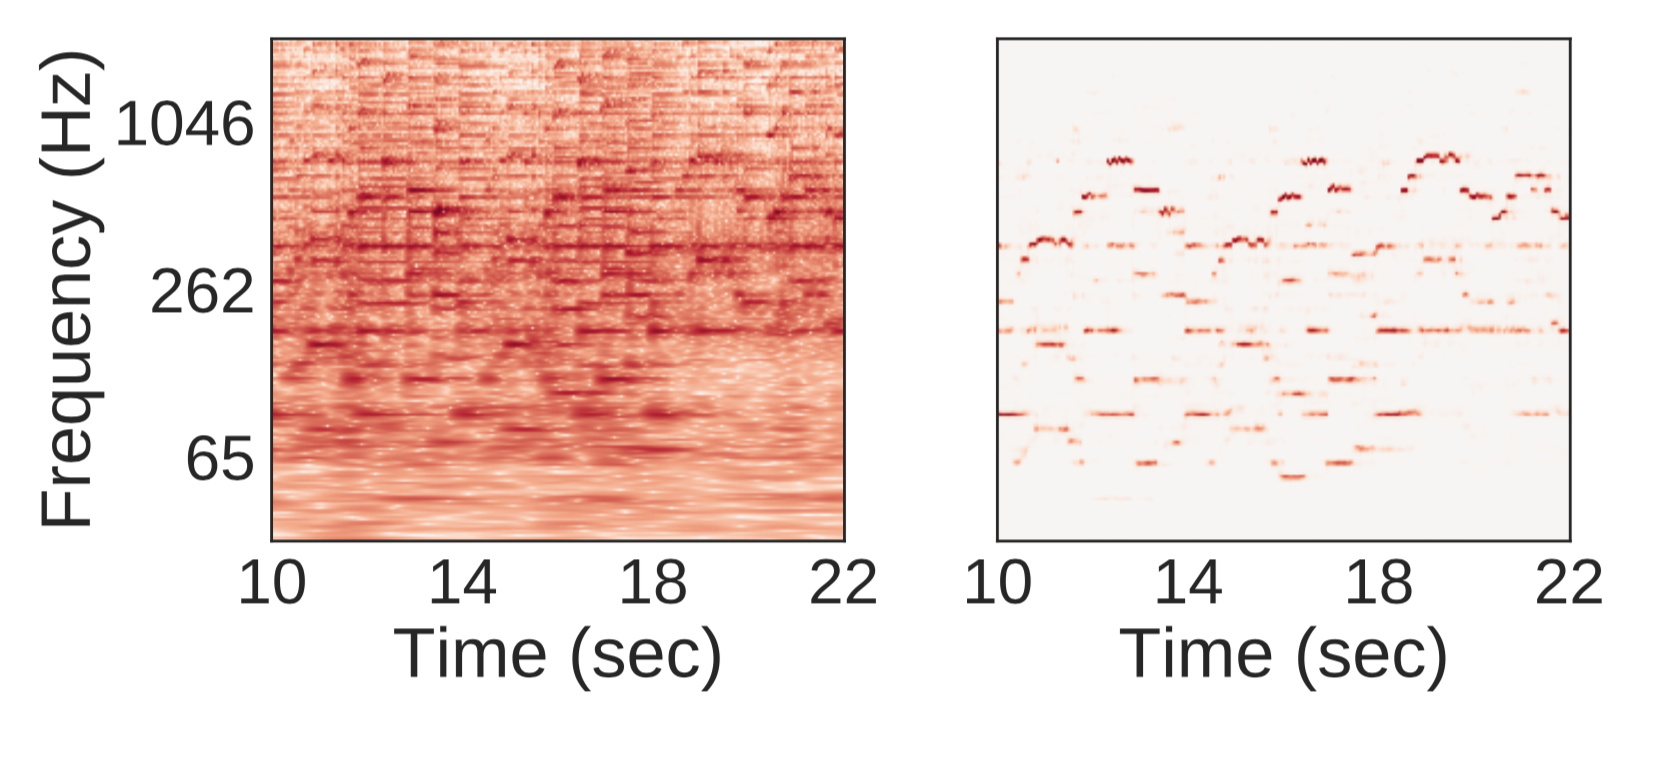

In [4]:
ipd.Image("attachment/mir02-tf2salience.png")  

3.最后从salience中解析出每一帧内有哪些音高，得到类似下图的结果（黑色为标准答案，红色为算法估计结果）。

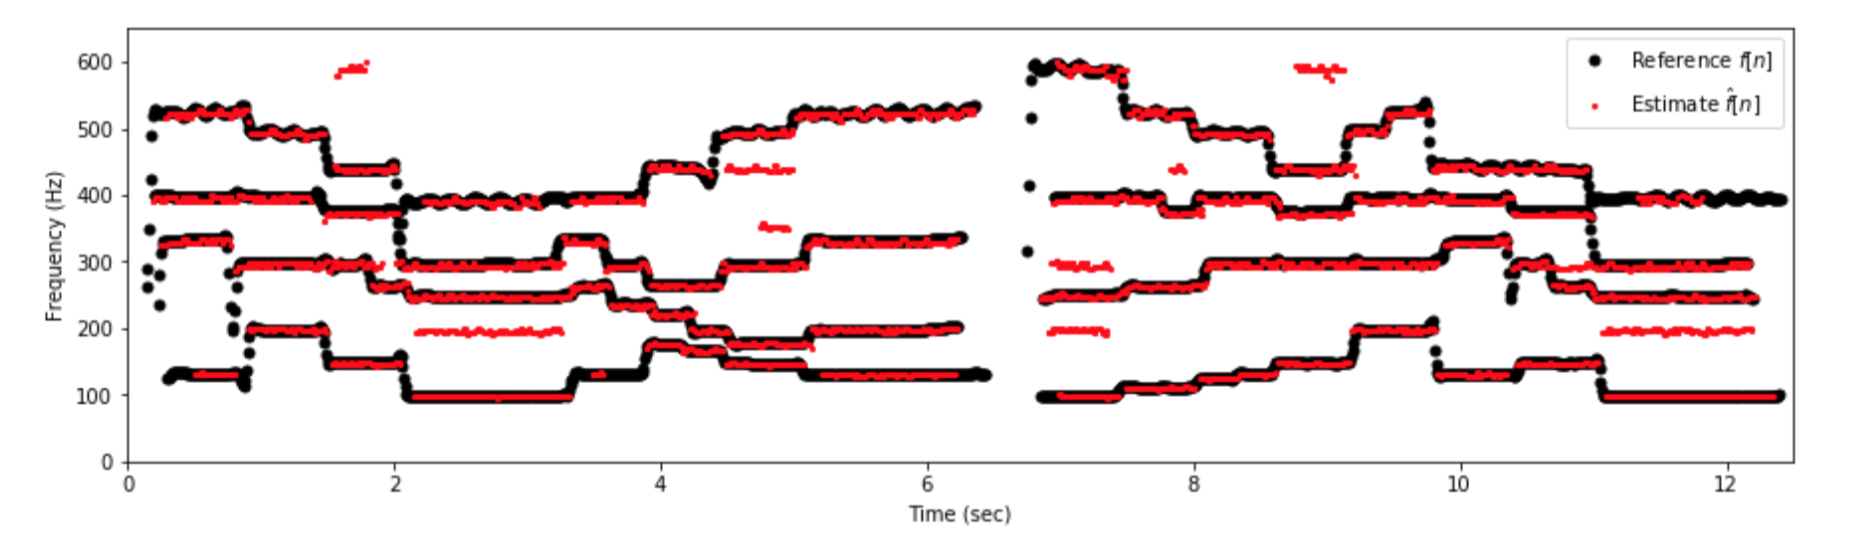

In [5]:
ipd.Image("attachment/mir02-multiplef0.png")  

目前第2步的主流方法是神经网络，在这之前比较火的是非负矩阵分解即NMF，并较为成功的应用在钢琴转录中(我的GitHub里有一款[python实现](https://github.com/beiciliang/modelAttackDecay-for-piano-transcription)，但关于钢琴转录目前最成功的是Google Magenta做出的Onsets and Frames: Dual-Objective Piano Transcription)。第3步中可以衍生出针对于歌曲主旋律的识别。

对详细的检测方法感兴趣的读者，推荐搜索以下前辈们的工作：

☞ “突显”时频谱的优化和F0识别：Rachel Bittner

☞ 针对于钢琴的F0识别：Emmanouil Benetos, Zhiyao Duan 

☞ 旋律识别：Justin Salamon, Juanjo Bosch

另外在之前2.1时域特征中，简单提到了单音识别，目前state-of-the-art是[CREPE: A Convolutional REpresentation for Pitch Estimation](https://github.com/marl/crepe)，在此之前应用比较广泛的纯信号处理方法为[pYIN: Probabilistic YIN](https://code.soundsoftware.ac.uk/projects/pyin)(龚嵘博士的GitHub里有python版本即[pypYIN](https://github.com/ronggong/pypYIN)).

---

### 『和弦识别』

如果说把音频中每个音高识别出来过于精细，也许只识别出和弦(chord)就能满足大多数吉他爱好者了！音高识别依赖于salience representation，而早年间对和弦的识别则依赖于色度图谱(chromagram)，这种图谱与一般时频谱的主要区别在于，它的纵轴不是频率的递增，而是12个音级(中央C和高音C这两个音差了八度，但他们的音级都是C，根据十二平均律我们有12个音级)。把时频谱上同一时间、同一音级、不同八度的音符的能量叠加该音级上，即得到该时间的色度图谱。如果此刻C、E、G三个音级上的能量较高，我们可以推测Cmaj和弦在演奏。

以色度图谱为起始点，Matthias Mauch在我们C4DM读博士期间提出的NNLS Chroma可以说是对和弦检测一个重要的提升，并一直作为MIREX和弦检测任务中类似baseline的存在，他也是Queen and Zweieck dataset的作者，并助攻Christopher Harte的Beatles dataset（话说MIREX里的JayChou29 dataset是Junqi Deng学长的功劳哦）。

但目前的主流方法……嗯对，又是神经网络，主要提升的点是对“非常见”和弦的检测力度。对详细检测过程感兴趣的话，可以搜索前文提到的学者，以及 Sebastian Böck, Johan Pauwels等等。

---

说实话，还有许多大大小小的数学细节和技术原理还没有讲到，下一节2.5也是“音频特征小全系列”最后一节将介绍一些常用的特征提取工具，之后我们再就着具体案例具体分析。

另外遥祝第6届中国声音与音乐技术会议圆满成功呀！下一届的时候我就人在国内可以参加了:)